# Getting started with Josiann

In this tutorial, we introduce the basics of working with *Josiann* on a simple cost function with noise.

We will show how to define and parametrize cost functions, use multiple move functions and choose parameters of the
Simulated Annealing (SA) algorithm.

In [1]:
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import numpy as np
import plotly.graph_objects as go

import numpy.typing as npt

import josiann as jo

/home/mbouvier/git/josiann/josiann/algorithms/sequential/base/sa.py:9: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



## Basic usage

The simplest way to use *Josiann* is the basic `josiann.sa()` algorithm. It expects a cost function whose input is a
position vector in n dimensions (a numpy.array with shape (n,)), evaluates a function at that position and returns a
single `float` value (i.e. the cost).

Here we will define a function which will square the position vector and add a random noise:

In [3]:
def cost_function(x: npt.NDArray[np.float64]) -> float:
    return np.sum(x ** 2) + np.random.normal(0, 3)

Let's represent that function when the position vector is in 2D space, bounded by [-3, -3] on the first axis and
 [0.5, 5] on the second axis. Since we compute the function only once at each position, it has a jagged appearance
 because of the noise term.

In the absence of noise, the global minimum within the bounds would be easy to find: (0, 0.5).

In [4]:
nx, ny = 100, 100

X = np.linspace(-3, 3, nx)
Y = np.linspace(0.5, 5, ny)

xv, yv = np.meshgrid(X, Y)
coords = np.concatenate((xv.flatten()[:, None], yv.flatten()[:, None]), axis=1)

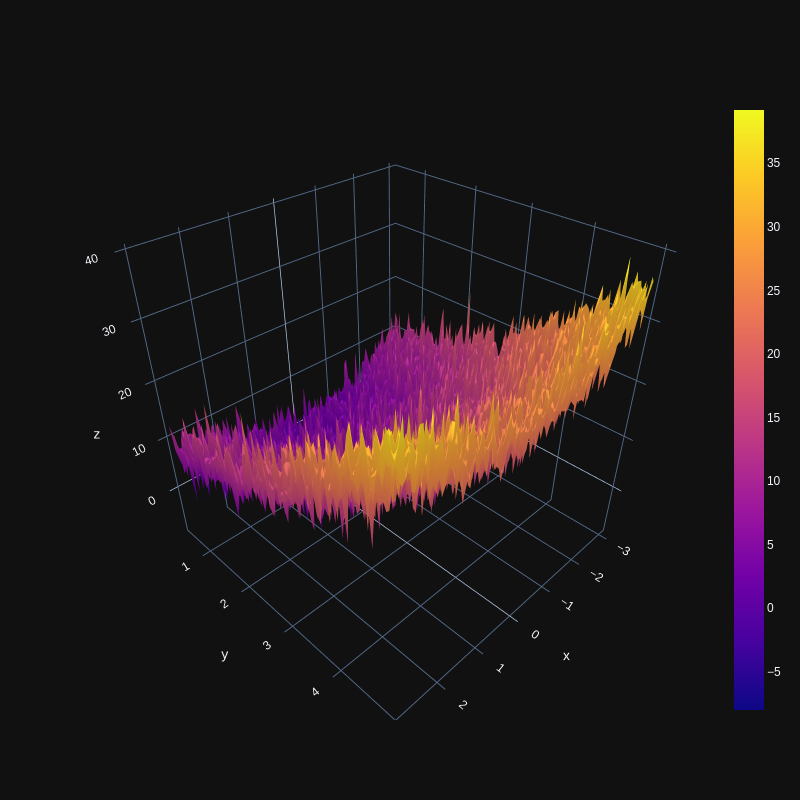

In [5]:
fig = go.Figure(data=[go.Surface(x=X, y=Y, z=np.array([cost_function(c) for c in coords]).reshape(nx, ny))])
fig.update_layout(height=800, width=800)
fig.show()

Let's run *Josiann* on that function:

We'll need to pass the cost function as first parameter. The second parameter defines the initial position vector and
 can be anything within the bounds of the problem (here we pick a position at random).

We then set the bounds of the problem and choose a *move* function to generate new position vectors. A common move
function is the Metropolis move where a new position is drawn at random from a multivariate normal distribution
centered on the current position.

Finally, we set parameters of the SA algorithm:
- max_iter: the maximum number of iteration to run
- max_measures: the maximum number of function evaluations at a given position
- T_0: the initial value for the Temperature parameter$
- seed: the seed for the random number generator

In [6]:
x0 = np.array([[np.random.randint(-3, 4), np.random.choice(np.linspace(0.5, 5, 10))]])

res = jo.sa(cost_function,
            x0,
            bounds=[(-3, 3), (0.5, 5)],
            moves=jo.Metropolis(variances=np.array([0.1, 0.1])),
            max_iter=200,
            max_measures=1000,
            T_0=5,
            seed=42)

  0%|          | 0/200 [00:00<?, ?iteration/s]

In [7]:
res

Result(
	message: Convergence tolerance reached.
	success: True
	trace: Trace of 187 iteration(s), 1 walker(s) and 2 dimension(s).
	best: [-0.10172863  0.5       ])

Here, we only ran for 187 iterations before *Josiann* detected it had converged on a solution. The best found position
vector was (-0.0771, 0.5), which is really close to the true minimum (0, 0.5).

We can obtain details on a run by plotting the evolution of parameters of the SA algorithm.

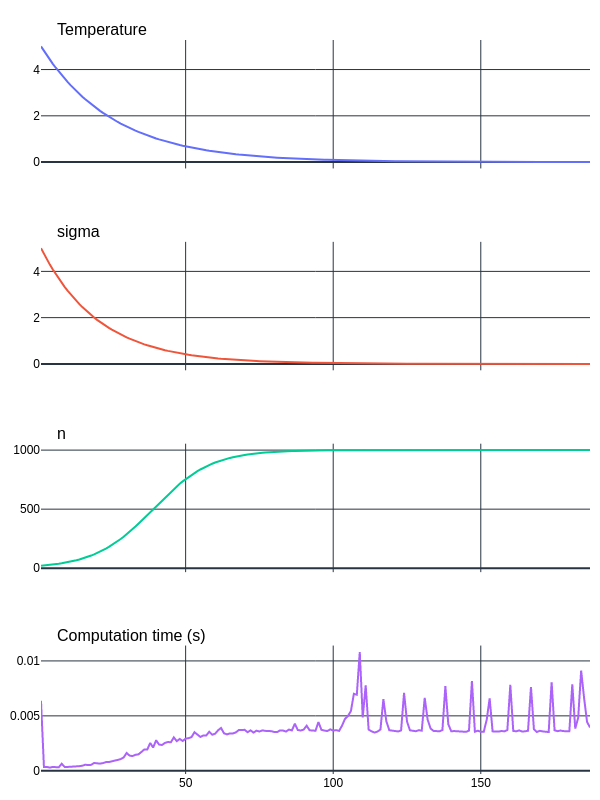

In [8]:
res.trace.plot_parameters()

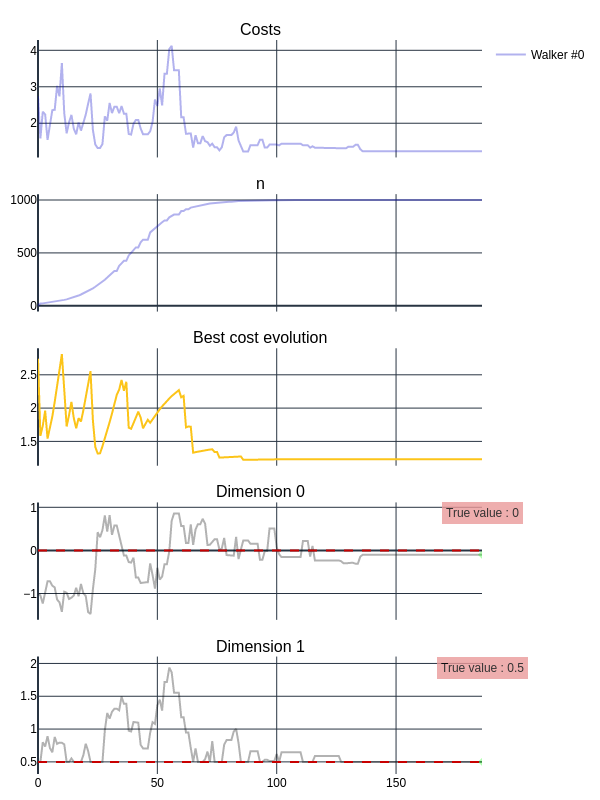

In [9]:
res.trace.plot_positions(true_values=[0, 0.5])

This plot is the most useful of the two: it shows how the position vector changed as iterations were computed,
alongside with its associated cost and number of function evaluations (n).

## Parametrizing the cost function

Sometimes, we want to use a cost function which accepts more than one input parameter. *Josiann* can pass additional
constant parameters using its `args` parameter.

As an example, let's modify the previous cost function by adding a variance parameter to choose the noise level.

In [10]:
def cost_function_with_arg(x: npt.NDArray[np.float64], var: float) -> float:
    return np.sum(x ** 2) + np.random.normal(0, var)

We can then run `josiann.sa()` as previously, passing the variance parameter in `args`:

In [11]:
x0 = np.array([[np.random.randint(-3, 4), np.random.choice(np.linspace(0.5, 5, 10))]])

res = jo.sa(cost_function_with_arg,
            x0,
            args=(3,),                                              # <-- a tuple of positional arguments to pass to
                                                                    # cost_function_with_arg() after the position vector.
            bounds=[(-3, 3), (0.5, 5)],
            moves=jo.Metropolis(variances=np.array([0.1, 0.1])),
            max_iter=200,
            max_measures=1000,
            T_0=5,
            seed=42)

  0%|          | 0/200 [00:00<?, ?iteration/s]

In [12]:
res

Result(
	message: Convergence tolerance reached.
	success: True
	trace: Trace of 187 iteration(s), 1 walker(s) and 2 dimension(s).
	best: [-0.07414436  0.5       ])

## Vectorized cost function

In this example, we will show how to we can speed up *Josiann* by using *vectorized cost functions*, *discrete moves*
and a *backup* system for caching past evaluations.

First, we need to define a vectorized cost function: it should accept a matrix of shape (w, n), where *w* is the
number of nD position vectors for which a cost must be computed, and should return a list of costs of length *w*.

In [13]:
def vectorized_cost_function(x: npt.NDArray[np.float64]) -> list[float]:
    return np.sum(x ** 2, axis=1) + np.random.normal(0, 1, size=len(x))

Then we define how many walkers we want (i.e. in this case: how many function evaluations can be computed at once).
This will allow to evaluate the cost function multiple times at the *same position vector* or at *multiple positions*
 quicker.

In [14]:
nb_walkers = 10

Finally, we will call the vectorized version of the SA algorithm `josiann.vsa()` and use a `josiann.SetStep` as move
function.

Because `josiann.SetStep` is a discrete step (working on a finite set of allow positions), the probability of obtaining
the same position vector twice is high and caching past function evaluations becomes interesting. Caching can be
enabled by setting the `backup` argument to true.
Compare how long it took to evaluate the cost function in the first run (no caching) vs the second run (caching
enabled) here below:

In [15]:
x0 = np.array([[np.random.randint(-3, 4), np.random.choice(np.linspace(0.5, 5, 10))] for _ in range(nb_walkers)])

res = jo.vsa(vectorized_cost_function,
             x0,
             bounds=[(-3, 3), (0.5, 5)],
             moves=jo.SetStep(position_set=[np.linspace(-3, 3, 25),
                                            np.linspace(0.5, 5, 19)]),
             nb_walkers=nb_walkers,
             max_iter=2000,
             max_measures=20_000,
             T_0=5,
             seed=42)

  0%|          | 0/2000 [00:00<?, ?iteration/s]

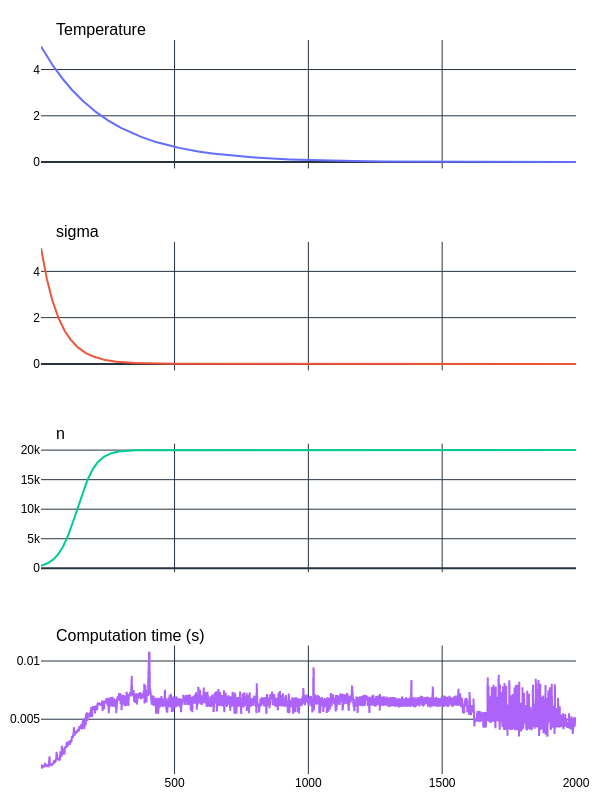

In [16]:
res.trace.plot_parameters()

In [17]:
res_backup = jo.vsa(vectorized_cost_function,
                    x0,
                    bounds=[(-3, 3), (0.5, 5)],
                    moves=jo.SetStep(position_set=[np.linspace(-3, 3, 25),
                                                   np.linspace(0.5, 5, 19)]),
                    nb_walkers=nb_walkers,
                    max_iter=2000,
                    max_measures=20_000,
                    T_0=5,
                    backup=True,
                    seed=42)

  0%|          | 0/2000 [00:00<?, ?iteration/s]

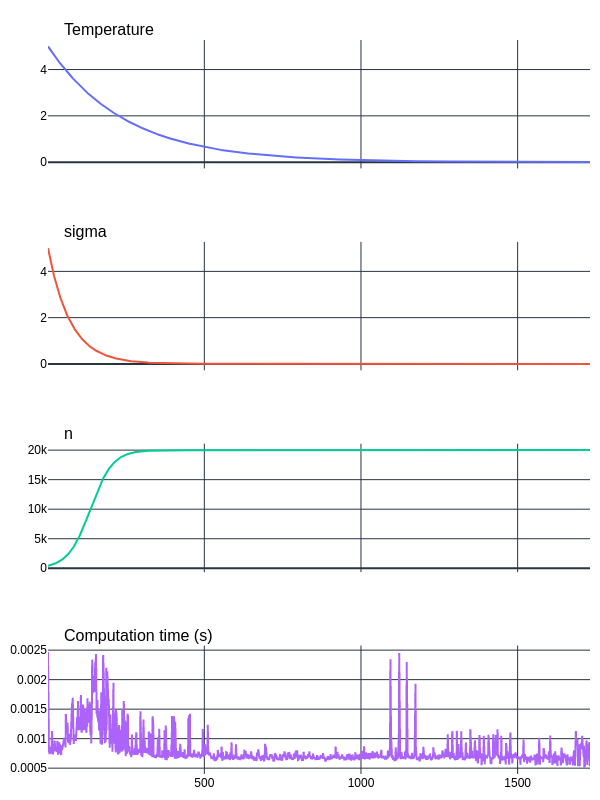

In [18]:
res_backup.trace.plot_parameters()
